To Do: 3/15/15
Chose capacity after edge choice - DONE
Update capacity pheromone - DONE
Scoring based on capacity: add super source and sink for later

In [1]:
%matplotlib inline

# Standard imports
import copy
import itertools

# Scientific computing imports
import numpy
import matplotlib.pyplot as plt
import networkx as nx
import pandas
import collections
from bisect import bisect
from networkx.algorithms.flow import edmonds_karp

import seaborn; seaborn.set()

# Import widget methods
from IPython.html.widgets import *

:0: FutureWarning: IPython widgets are experimental and may change in the future.


In [32]:
class Ant(object):
    """
    Ant class, which encapsulates the entire behavior of an ant.
    """
    def __init__(self,model,ant_id):
    
        # Set model link and ID
        self.model = model
        self.ant_id = ant_id
        
    def random_walk(self,source,sink):
        #Random Walk
        #initialize
        self.source=source
        print('walk source',self.source)
        self.sink=sink
        #print(self.sink)
        self.g=nx.DiGraph()
        self.last_nodes=self.source
        #self.last_nodes.append(self.source)


        #Agent Step
        terminate=0
        while not terminate:
            terminate=1
            for i in xrange(len(self.last_nodes)):
                #track next nodes
                self.last_nodes_next=[]
                #get neighbors
                self.base_node=self.last_nodes[i]
                #self.base_node=self.last_nodes.pop()
                self.p_neighbors=self.get_neighbors(self.base_node)
                
                #get pheromone of each edge to neighbor
                self.edge_pheromone_list=[]
                for self.potential_node in self.p_neighbors:
                    self.edge_pheromone_list.append(self.get_pheromone_edge((self.base_node,self.potential_node)))
                
                #get next node
                self.next_node=self.p_neighbors[self.make_decision(self.edge_pheromone_list)]
                self.last_nodes_next.append(self.next_node)
                
                #add edge
                self.g.add_edge(self.base_node,self.next_node)
                #print(self.g.nodes())
                
                #get capacity pheromones
                self.capacity_pheromone_list=self.get_pheromone_capacity((self.base_node,self.next_node))
                
                #decide capacity
                self.capacity_to_add=self.model.capacities[self.make_decision(self.capacity_pheromone_list)]
                
                #add capacity
                self.g[self.base_node][self.next_node]['capacity']=self.capacity_to_add
                
                #Check termination criteria
                for sink_node in self.sink:
                    if sink_node not in self.g:
                        terminate=0
                        
            self.last_nodes=self.last_nodes_next   

        return (self.g)
    
    def get_neighbors(self,node):
        """
        Return neighbors, calling through model.
        """
        return self.model.get_ant_neighbors(node)
    
    def make_decision(self,pheromone_list):
        """
        Return decision index, based on pheromone list.
        """
        #convert pheromones to percentage
        self.percent_list = [float(i)/sum(pheromone_list) for i in pheromone_list]   
        self.cumulative_percent=numpy.cumsum(self.percent_list)

        #Choose decision index
        self.select_index=bisect(self.cumulative_percent,numpy.random.uniform(0,1,1))
  
        return self.select_index
    
    
    #def get_pheromone_node(self,node):
        """
        Return node pheromone, calling through model.
        """    
    
    
    def get_pheromone_edge(self,edge):
        """
        Return edge pheromone, calling through model.
        """
        return self.model.get_edge_pheromone(edge)

    def get_pheromone_capacity(self,edge):
        """
        Return edge pheromone, calling through model.
        """
        return self.model.get_capacity_pheromone(edge)
    

    def __repr__(self):
        '''
        Return string representation.
        '''
        skip_none = True
        repr_string = type(self).__name__ + " ["
        except_list = "model"

        elements = [e for e in dir(self) if str(e) not in except_list]
        for e in elements:
            # Make sure we only display "public" fields; skip anything private (_*), that is a method/function, or that is a module.
            if not e.startswith("_") and eval('type(self.{0}).__name__'.format(e)) not in ['DataFrame', 'function', 'method', 'builtin_function_or_method', 'module', 'instancemethod']:
                    value = eval("self." + e)
                    if value != None and skip_none == True:
                        repr_string += "{0}={1}, ".format(e, value)

        # Clean up trailing space and comma.
        return repr_string.strip(" ").strip(",") + "]"

    

In [43]:
class Space(object):
    """
    Space class, which encapsulates the entire behavior of a single "run" ACO.
    """
    def __init__(self, size,num_ants=1,source=[[(0,0)],[10]],sink=[[(2,2)],[5]],dissipation=.8,pheromone_drop=.5,capacities=[1,5,10]):
        """
        Class constructor.
        """
        # Set our model parameters
        self.size = size
        self.sink = sink[0]
        print(self.sink)
        self.sink_magnitude = sink[1]
        self.source=source[0]
        print(self.source)
        self.source_magnitude = source[1]        
        self.num_ants=num_ants
        self.dissipation=dissipation
        self.pheromone_drop=pheromone_drop
        self.capacities=capacities
        
        # Set our state variables
        self.t = 0
        self.ants = []

        
        # Call our setup methods to initialize space, people, and institution.
        self.setup_space()
        self.setup_ants()
        

    def setup_space(self):
        """
        Method to setup our space.
        """
        # Initialize a space with a grid network
        self.g = nx.grid_graph(dim=[self.size,self.size])
        self.g=self.g.to_directed()
        
        #Set Pheromones
        print('Setting up network')
        for e in self.g.edges_iter():
            self.g.add_edge(e[0],e[1],capacity=0)
            self.g.add_edge(e[0],e[1],edge_pheromone=1)
            self.g.add_edge(e[0],e[1],capacity_pheromone=[1,1,1])
            #print(self.g[e[0]][e[1]])

        self.g_layout = nx.spectral_layout(self.g)
        #print(nx.get_edge_attributes(self.g,'capacity_pheromone'))

        #nx.draw_networkx(self.g, pos=self.g_layout, node_color='#dddddd')
        #print((self.g.number_of_nodes(), self.g.number_of_edges()))

        #plt.show() 
        
    def setup_ants(self):
        """
        Method to setup our space.
        """
        
        # First, begin by creating all ants.
        for i in xrange(self.num_ants):
            self.ants.append(Ant(model=self,ant_id=i))
            
    def get_edge_pheromone(self,edge):
        """
        Get edge decision pheromone for ant call
        """        
        return self.g[edge[0]][edge[1]]['edge_pheromone']
    
    def get_capacity_pheromone(self,edge):
        """
        Get edge decision pheromone for ant call
        """        
        return self.g[edge[0]][edge[1]]['capacity_pheromone']
        
        
    def get_ant_neighbors(self,node):
        """
        Get node neighbors for ant call
        """
        return self.g.neighbors(node)
            
    def get_path(self, ant_id):
        """
        Get the path of an ant based on their ID.
        """
        print('get source',self.source)
        print('get sink',self.sink)
        return self.ants[ant_id].random_walk(self.source,self.sink)
    
    def evaluate_graph(self, ant_graph):
        """
        Score graphs based on criteria.
        """
        #Score 1 - Length
        length=ant_graph.number_of_edges()
        
        #Score 2 - Flow
        #add aggregate sink
        flow_graph=ant_graph.copy()
        for i in xrange(len(self.sink)):
            flow_graph.add_edge(self.sink[i],'sink',capacity=self.sink_magnitude[i])
        
        #add aggregate source
        for i in xrange(len(self.source)):
            flow_graph.add_edge('source',self.source[i],capacity=self.source_magnitude[i])
        
        flow_value, flow_dict = nx.maximum_flow(flow_graph, 'source', 'sink')
        
        score=float(flow_value)/sum(self.sink_magnitude)
        print(score)
        
        return score
        
        
    def ant_ranking(self, ant_graphs):
        """
        Find best Ants based on scores from evaluate_graph.
        """
        score_list=[]
        [score_list.append(graph[1]) for graph in ant_graphs]
        print(score_list)
        
        best_ants_index=[]
        [best_ants_index.append(i) for i, j in enumerate(score_list) if j == max(score_list)]
        return best_ants_index, score_list
        
    def step(self):
        """
        Model step function.
        """
        #Ants make paths
        self.ant_graphs=[]
        
        #Step for each ant
        for i in xrange(self.num_ants):
            print('pre-path',self.source)
            self.ant_graph=self.get_path(i)
            print('post-path',self.source)
            #Evaluate Paths
            # Clear print('pre-score',self.source)
            self.graph_score=self.evaluate_graph(self.ant_graph) 
            # Clear print('post-score',self.source)
            
            #List <graph,score>
            self.ant_graphs.append((self.ant_graph,self.graph_score))
            
        #Get best score
        self.opt_ant,self.score_list=self.ant_ranking(self.ant_graphs)
        #print('Best ants:',self.opt_ant,'Score:',self.ant_graphs[self.opt_ant[0]][1])
        
        #Update Institutions - Edges and capacities for this walk
        #Get pheromones
        self.edge_pheromone_dict=nx.get_edge_attributes(self.g,'edge_pheromone')
        self.capacity_pheromone_dict=nx.get_edge_attributes(self.g,'capacity_pheromone')
        
        #Reduce edge pheromones by input amount
        for key in self.edge_pheromone_dict:    
            self.edge_pheromone_dict[key]*=self.dissipation      
      
        #Increment through best paths to update
        for ant in self.opt_ant:
            #print(ant)
            #print(self.ant_graphs[ant][0].edges())
            for e in self.ant_graphs[ant][0].edges():
                #increase the pheromone amount of edges traveled by best ants
                self.edge_pheromone_dict[e]+=self.pheromone_drop
                
                #get capacity chosen and update pheromones
                self.capacity_chosen=self.ant_graphs[ant][0][e[0]][e[1]]['capacity']
                self.capacity_index=self.capacities.index(self.capacity_chosen)
                for i in xrange(len(self.capacity_pheromone_dict[e])):
                    self.capacity_pheromone_dict[e][i]*=self.dissipation
                    
                    #add pheromone if one chosen
                    if i == self.capacity_index:
                        self.capacity_pheromone_dict[e][i]+=self.pheromone_drop
            
            
        #self.best_ant_edge_list=list(self.best_ant_edge_set)
                                      

            
        
        #Set new edge pheromones
        nx.set_edge_attributes(self.g, 'edge_pheromone', self.edge_pheromone_dict)
        
        #Set new capacity pheromones
        nx.set_edge_attributes(self.g, 'capacity_pheromone', self.capacity_pheromone_dict)
        
        
            
        
            

        
                                      

[(2, 2)]
[(0, 0)]
Setting up network


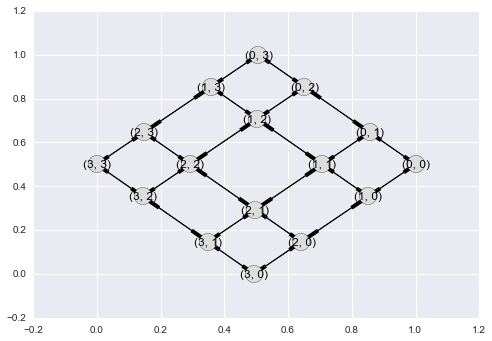

('pre-path', [(0, 0)])
('get source', [(0, 0)])
('get sink', [(2, 2)])
('walk source', [(0, 0)])
('post-path', [(0, 0)])
1.0
('pre-path', [(0, 0)])
('get source', [(0, 0)])
('get sink', [(2, 2)])
('walk source', [(0, 0)])
('post-path', [(0, 0)])
0.2
('pre-path', [(0, 0)])
('get source', [(0, 0)])
('get sink', [(2, 2)])
('walk source', [(0, 0)])
('post-path', [(0, 0)])
0.2
('pre-path', [(0, 0)])
('get source', [(0, 0)])
('get sink', [(2, 2)])
('walk source', [(0, 0)])
('post-path', [(0, 0)])
1.0
('pre-path', [(0, 0)])
('get source', [(0, 0)])
('get sink', [(2, 2)])
('walk source', [(0, 0)])
('post-path', [(0, 0)])
1.0
[1.0, 0.2, 0.2, 1.0, 1.0]
Ant Path
(<networkx.classes.digraph.DiGraph object at 0x0000000018094E10>, 1.0)
10
5
5
10
10
10


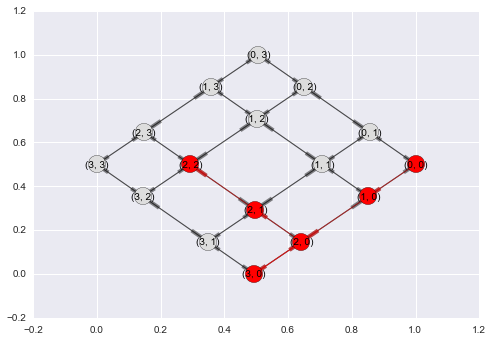

In [44]:
space=Space(size=4,num_ants=5,pheromone_drop=.3)
nx.draw_networkx(space.g, pos=space.g_layout, node_color='#dddddd')
#print((space.g.number_of_nodes(), space.g.number_of_edges()))

plt.show()  

space.step()

print('Ant Path')
print(space.ant_graphs[0])
test_graph=space.ant_graphs[space.opt_ant[0]][0]
for u,v in test_graph.edges():
    print(test_graph[u][v]['capacity'])

#p_el=[]

#for i in range(0,len(space.ant_paths[0])-1):
   # p_el.append((space.ant_paths[0][i],space.ant_paths[0][i+1]))
    

# Remove the infected from healthy nodes
nonpath_nodes = [node for node in space.g.nodes() if node not in space.ant_graphs[space.opt_ant[0]][0]]

#for u,v in space.g.edges():
#    print(space.g[u][v]['edge_pheromone'])

# Now we can visualize the infected node's position
f = plt.figure()
nx.draw_networkx_nodes(space.ant_graphs[space.opt_ant[0]][0], space.g_layout,
                       node_color='red',edge_color='red')

nx.draw_networkx_nodes(space.g, space.g_layout,
                       nodelist=nonpath_nodes,
                       node_color='#dddddd')

nx.draw_networkx_edges(space.g, space.g_layout, 
                       width=1.0, 
                       alpha=0.5,
                       edge_color='#111111')

nx.draw_networkx_edges(space.ant_graphs[space.opt_ant[0]][0], space.g_layout,
                      edgelist=space.ant_graphs[space.opt_ant[0]][0].edges(),
                      width=1.0, 
                      alpha=0.5,
                      edge_color='red')


_ = nx.draw_networkx_labels(space.g, space.g_layout,
                        dict(zip(space.g.nodes(), space.g.nodes())),
                        font_size=10)

1
('pre-path', [(0, 0)])
('get source', [(0, 0)])
('get sink', [(2, 2)])
('walk source', [(0, 0)])
('post-path', [(0, 0)])
1.0
('pre-path', [(0, 0)])
('get source', [(0, 0)])
('get sink', [(2, 2)])
('walk source', [(0, 0)])
('post-path', [(0, 0)])
1.0
('pre-path', [(0, 0)])
('get source', [(0, 0)])
('get sink', [(2, 2)])
('walk source', [(0, 0)])
('post-path', [(0, 0)])
1.0
('pre-path', [(0, 0)])
('get source', [(0, 0)])
('get sink', [(2, 2)])
('walk source', [(0, 0)])
('post-path', [(0, 0)])
1.0
('pre-path', [(0, 0)])
('get source', [(0, 0)])
('get sink', [(2, 2)])
('walk source', [(0, 0)])
('post-path', [(0, 0)])
1.0
[1.0, 1.0, 1.0, 1.0, 1.0]
Ant Path
1.67267890586
0.675124928512
2.30787590963
1.60584400691
2.13078769869
2.49408134963
1.38753960141
0.355195027456
0.222319476736
0.119051124736
1.73355209114
1.73568193946
0.603220443136
0.119051124736
0.272651124736
0.833372305408
0.304863379456
0.395460345856
0.355195027456
0.119051124736
0.340164345856
0.191528697856
0.920848709632
3

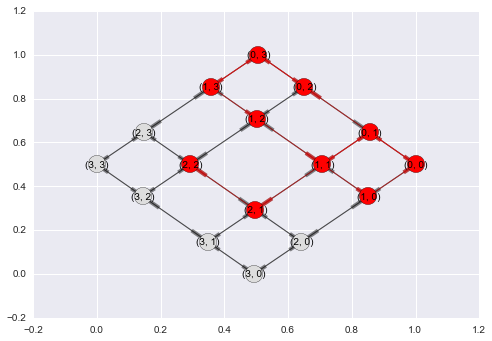

In [46]:
converged=0
i=1
while not converged:
    print(i)
    space.step()
    i+=1
    
    scores=space.score_list
    #check convergence
    if all(scores[0] == item for item in scores):
        converged=1
    
    if i>50:
        converged=1
        

print('Ant Path')
#print(space.ant_graphs[0])
#print(space.ant_graphs[0][0].edges())

#p_el=[]

#for i in range(0,len(space.ant_paths[0])-1):
   # p_el.append((space.ant_paths[0][i],space.ant_paths[0][i+1]))
    

# Remove the infected from healthy nodes
nonpath_nodes = [node for node in space.g.nodes() if node not in space.ant_graphs[space.opt_ant[0]][0]]

for u,v in space.g.edges():
    print(space.g[u][v]['edge_pheromone'])

# Now we can visualize the infected node's position
f = plt.figure()
nx.draw_networkx_nodes(space.ant_graphs[space.opt_ant[0]][0], space.g_layout,
                       node_color='red',edge_color='red')

nx.draw_networkx_nodes(space.g, space.g_layout,
                       nodelist=nonpath_nodes,
                       node_color='#dddddd')

nx.draw_networkx_edges(space.g, space.g_layout, 
                       width=1.0, 
                       alpha=0.5,
                       edge_color='#111111')

nx.draw_networkx_edges(space.ant_graphs[space.opt_ant[0]][0], space.g_layout,
                      edgelist=space.ant_graphs[space.opt_ant[0]][0].edges(),
                      width=1.0, 
                      alpha=0.5,
                      edge_color='red')


_ = nx.draw_networkx_labels(space.g, space.g_layout,
                        dict(zip(space.g.nodes(), space.g.nodes())),
                        font_size=10)

In [47]:
print(nx.get_edge_attributes(space.ant_graphs[space.opt_ant[0]][0],'capacity'))
#print(nx.get_edge_attributes(space.g,'capacity_pheromone'))
#print(space.ant_graphs[space.opt_ant[0]][0][(0,0)][(0,1)]['capacity'])
capacities=[1,5,10]
#print(capacities.index(space.ant_graphs[space.opt_ant[0]][0][(0,0)][(0,1)]['capacity']))
for i in xrange(len(capacities)):
    capacities[i]*=2
    
#print(capacities)
    

{((1, 2), (1, 1)): 5, ((0, 0), (0, 1)): 5, ((0, 1), (0, 2)): 1, ((2, 1), (2, 2)): 10, ((1, 0), (0, 0)): 5, ((1, 1), (0, 1)): 10, ((1, 1), (1, 0)): 10, ((1, 3), (1, 2)): 1, ((0, 3), (1, 3)): 10, ((1, 1), (2, 1)): 10, ((0, 1), (0, 0)): 10, ((0, 1), (1, 1)): 5, ((1, 3), (0, 3)): 5, ((0, 3), (0, 2)): 1, ((0, 2), (0, 3)): 1}


In [ ]:
G = nx.Graph()   # or DiGraph, MultiGraph, MultiDiGraph, etc
G.add_path([0,1,2])
G.has_node(0)

In [53]:
def simple_cull(inputPoints, dominates):
    paretoPoints = set()
    candidateRowNr = 0
    dominatedPoints = set()
    while True:
        candidateRow = inputPoints[candidateRowNr]
        inputPoints.remove(candidateRow)
        rowNr = 0
        nonDominated = True
        while len(inputPoints) != 0 and rowNr < len(inputPoints):
            row = inputPoints[rowNr]
            if dominates(candidateRow, row):
                # If it is worse on all features remove the row from the array
                inputPoints.remove(row)
                dominatedPoints.add(tuple(row))
            elif dominates(row, candidateRow):
                nonDominated = False
                dominatedPoints.add(tuple(candidateRow))
                rowNr += 1
            else:
                rowNr += 1

        if nonDominated:
            # add the non-dominated point to the Pareto frontier
            paretoPoints.add(tuple(candidateRow))

        if len(inputPoints) == 0:
            break
    return paretoPoints, dominatedPoints

In [61]:
def dominates(row, candidateRow):
    return sum([row[x] >= candidateRow[x] for x in range(len(row))]) == len(row)    

#inputPoints = [[1,1,1], [1,2,3], [3,2,1], [4,1,1]]
inputPoints = [[1,1], [1,2], [3,2], [4,1]]
paretoPoints, dominatedPoints = simple_cull(inputPoints, dominates)

print "*"*8 + " non-dominated answers " + ("*"*8)
for p in paretoPoints:
    print p
print "*"*8 + " dominated answers " + ("*"*8)
for p in dominatedPoints:
    print p

******** non-dominated answers ********
(3, 2)
(4, 1)
******** dominated answers ********
(1, 2)
(1, 1)


In [57]:
'''
Method to take two equally-sized lists and return just the elements which lie 
on the Pareto frontier, sorted into order.
Default behaviour is to find the maximum for both X and Y, but the option is
available to specify maxX = False or maxY = False to find the minimum for either
or both of the parameters.
'''
def pareto_frontier(Xs, Ys, maxX = True, maxY = True):
# Sort the list in either ascending or descending order of X
    myList = sorted([[Xs[i], Ys[i]] for i in range(len(Xs))], reverse=maxX)
# Start the Pareto frontier with the first value in the sorted list
    p_front = [myList[0]]    
# Loop through the sorted list
    for pair in myList[1:]:
        if maxY: 
            if pair[1] >= p_front[-1][1]: # Look for higher values of Y…
                p_front.append(pair) # … and add them to the Pareto frontier
        else:
            if pair[1] <= p_front[-1][1]: # Look for lower values of Y…
                p_front.append(pair) # … and add them to the Pareto frontier
# Turn resulting pairs back into a list of Xs and Ys
    p_frontX = [pair[0] for pair in p_front]
    p_frontY = [pair[1] for pair in p_front]
    return p_frontX, p_frontY

In [60]:
x=[1,1,3,4]
y=[1,2,2,1]
pareto_frontier(x,y,maxX=False,maxY=False)

([1, 4], [1, 1])